Import library :

In [ ]:
import pickle 
import numpy as np 
import pandas as pd
import networkx as nx
from tqdm import tqdm
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import community
import collections
import seaborn.objects as so
from scipy.stats import chi2_contingency
import matplotlib.lines as mlines
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import plotly.subplots as sp
import matplotlib.cm as cm

from src.utils.data_utils import *
from src.utils.general_utils import *
from src.utils.mapping import *
from src.utils.langue import *
from src.utils.career import *

Import data set :

In [ ]:
movie_path = 'data/Movie.pkl'
actors_path = 'data/Actor.pkl'
Movie = pd.read_pickle(movie_path)
Actor = pd.read_pickle(actors_path)

# Actor Network : Career

In [ ]:
# create dataset for career analysis 
Actor_career = create_actor_career_dataset(Actor)

## Career clustering

In [ ]:
# drop unnecessary columns and scale value in prevision of making KNN
Career_dataset_std = prepare_career_dataset_KNN(Actor_career)

In [ ]:
# plot elbow to select suitable number of cluster
plot_elbow_method(Career_dataset_std,range(1,10),random_state=50)

In [ ]:
#set number of cluster based on elbow plot :
n_cluster = 3
#do clustering relatively to the  n cluster 
labels = knn_clustering(Career_dataset_std, n_cluster, random_state=50)
# add a column label
Actor_career['Labels'] = labels

In [ ]:
#plot the condroids of number movie per year for ewach cluster
plot_career_data(Actor_career,labels,n_clusters=n_cluster)

In [ ]:
#plot career of our brother Yao Ming
plot_career_data(Actor_career, labels,"Yao Ming")

In [ ]:
#most prolific actor 
plot_career_data(Actor_career,labels,"Mel Blanc")

In [ ]:
#Well known and very prolific
plot_career_data(Actor_career,labels,"Samuel L. Jackson")

In [ ]:
#Well known and very prolific
plot_career_data(Actor_career,labels,"Johnny Depp")

In [ ]:
plot_cluster_histogram(Actor_career, 'Total_nbr_films', n_clusters=3, bin_width=3,logscale = True,max_value=300, min_value=-5, alpha = 0.5)

In [ ]:
plot_cluster_histogram(Actor_career, 'actor_height', n_clusters=n_cluster, bin_width=0.03, max_value=2.5, min_value=0.5, logscale = True)

In [ ]:
dict_cluster = get_dict_cluster(n_cluster, Actor_career, label_column='Labels')
# get successfull df
success = dict_cluster[1]
success[success["actor_height"]<1.5]

In [ ]:
plot_cluster_histogram(Actor_career, 'Career_Start_age', n_clusters=n_cluster, bin_width=1,kde_option = True,Pourcentage = True, alpha = 0.5)

In [ ]:
plot_cluster_histogram(Actor_career, 'Career_length', n_clusters=n_cluster, bin_width=1,Pourcentage = False,logscale = True)

In [ ]:
plot_gender_proportions_by_cluster(Actor_career)

# Actor Network through languages

## Actor Network and indentifying the language of the film

In [18]:
G = custom_create_actor_network(Actor, Movie, min_movies= 90)

Creating network: 100%|██████████| 10205/10205 [00:15<00:00, 679.73it/s] 

time to compute: 15.5 seconds


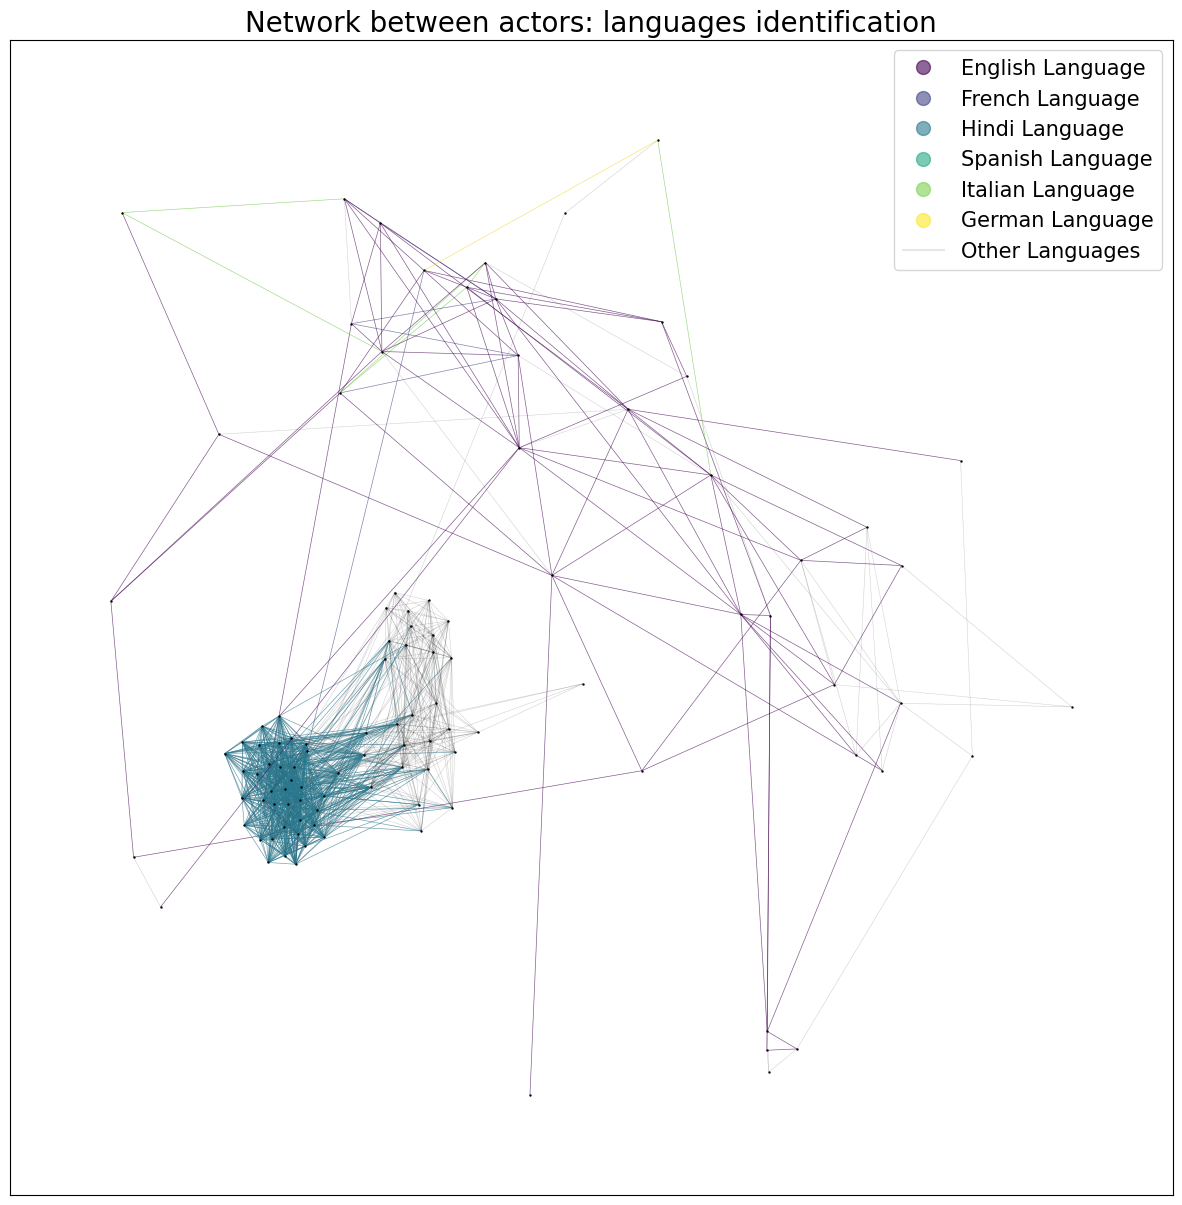

time to compute: 1.6 seconds


In [19]:
plot_network_with_language(G, save =True)

## Movie language

Do the actors playing in a language play in movie in other language ?

In [20]:
nb_language = 6
#create a dataset of actor that have played in "nb_language" most represeted languages. set 1 if appear in a language, 0 otherwise
actor_language = create_actor_language_dataset(Movie, Actor, nb_language)

In [21]:
# creat a dict per languages kept. each value are df only with actor that have played in this specific language
actor_count_per_language = create_cross_language(actor_language)

In [22]:
# plot previous dict (one for each languages kept)
plot_language_histograms(actor_count_per_language, save = False)

**QUIZZ : Which actor has appeared in films of 9 out of the 10 most spoken movie languages?**

In [23]:
#create dataset with the 10 most spoken movie languages :
actor_language2 = create_actor_language_dataset(Movie, Actor, 10)

In [24]:
one_zero = (actor_language2 > 0).astype(int)
one_zero["sum"] = one_zero.sum(axis=1)
freebase_id = one_zero[one_zero["sum"]>8].index.to_list()
one_zero[one_zero["sum"]>8]

languages_played = one_zero[one_zero["sum"] > 8].iloc[:, :-1] 
languages_played_columns = languages_played.columns[languages_played.iloc[0] == 1]
print(f"The actor is Jacky Chan {freebase_id}, and has played in \n {languages_played_columns.to_list()}")

The actor is Jacky Chan ['/m/012d40'], and has played in 
 ['English Language', 'Hindi Language', 'Spanish Language', 'French Language', 'Italian Language', 'German Language', 'Japanese Language', 'Tamil Language', 'Malayalam Language']


## Relationship between English movie and expatriation :

In [25]:
# create dict containing a dict with a key per movie language.
# for each key : there is the actor that have played in this language with all other movie languages played in (with the count of movie per languages)
movie_count_per_language = create_cross_language_count(actor_language)

Pour les actor ayant joué en anglais, regardons si nous avons la même distribution de langue selon le nombre de film. Voici 4 groupes d'acteur différents :

- **group 1** : $1 \leq \text{nb\_movie} \leq 5$
- **group 2** : $6 \leq \text{nb\_movie} \leq 10$
- **group 3** : $11 \leq \text{nb\_movie} \leq 25$
- **group 4** : $26 \leq \text{nb\_movie}$

In [26]:
# select all actors that have been played in english
movie_count_english=movie_count_per_language['English Language']

In [27]:
# create a dict that has a key per group and movie count per language per actor
dict_group = create_group(movie_count_english)

Size of groups : (65534, 5545, 4315, 1863)


In [28]:
# create a dict that has a key per group and the movie count distribution for each language
distribution_dict = create_distribution_for_each_group(dict_group, number_group = 4)

We are interested to see if the people with large or few total movie number have the same language distribution. <br> Let's do a Chi2 test !

**Null hypothesis** : the distribution between languages (for actor that have at least played once in english movie) is independant of the number of movie that an actor has played in.

In [29]:
# take correct shape of the distribution to be tested on a CHi2 test :
matrix = pd.DataFrame(distribution_dict, index=[1,2,3,4]).T
# do chi2 test
chi2, p_value, dof, expected = chi2_contingency(matrix)
#print result
print_result_chi2(chi2, p_value, dof, expected)

Chi-2 : 14399.536470883602
P-value : 0.0
degree of freedom : 15
Distribution are significantly statistically different (p < 0.05).


In [30]:
nb_group = 4 # we test 4 groups of actor (depending of their number of movie played in)
# get the 5 most represented movie languages.
list_languages = get_most_represented_language(Movie, nb_language) 

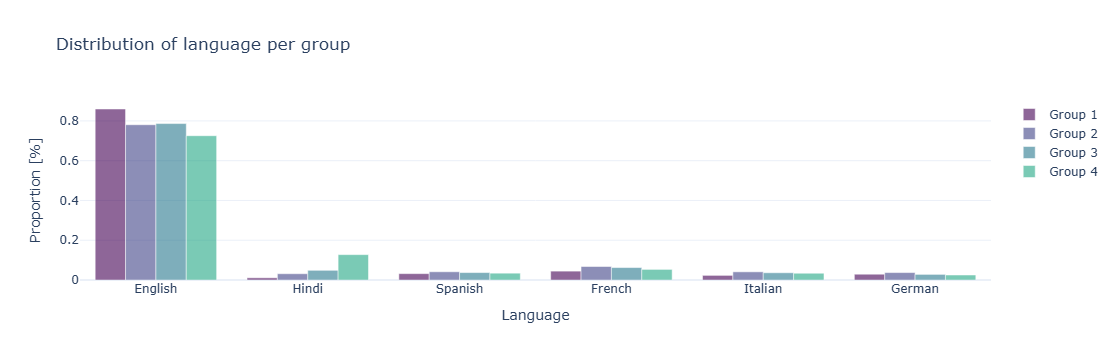

In [31]:
plot_group_distribution_language(matrix, nb_group, list_languages,save=False)